##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [2]:
# %pip install pandas 
# %pip install matplotlib
# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME 

## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and 
##### have the .parquet file inside that. A relative path *must* be used when loading data into pandas

In [3]:
# Dependencies
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import LabelEncoder

# Filepath
filepath = "./data/catB_train.csv" 

### **ALL** Code for machine learning and dataset analysis should be entered below. 
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.

In [4]:
# read data
df = pd.read_csv(filepath)

# display first five rows
pd.set_option('display.max_columns', None)
df.head()

,Unnamed: 0,clntnum,race_desc,ctrycode_desc,clttype,stat_flag,min_occ_date,cltdob_fix,cltsex_fix,flg_substandard,flg_is_borderline_standard,flg_is_revised_term,flg_is_rental_flat,flg_has_health_claim,flg_has_life_claim,flg_gi_claim,flg_is_proposal,flg_with_preauthorisation,flg_is_returned_mail,is_consent_to_mail,is_consent_to_email,is_consent_to_call,is_consent_to_sms,is_valid_dm,is_valid_email,is_housewife_retiree,is_sg_pr,is_class_1_2,is_dependent_in_at_least_1_policy,f_ever_declined_la,hh_20,pop_20,hh_size,hh_size_est,annual_income_est,n_months_last_bought_products,flg_latest_being_lapse,flg_latest_being_cancel,recency_lapse,recency_cancel,tot_inforce_pols,tot_cancel_pols,ape_gi_42e115,ape_ltc_1280bf,ape_grp_6fc3e6,ape_grp_de05ae,ape_inv_dcd836,ape_grp_945b5a,ape_grp_6a5788,ape_ltc_43b9d5,ape_grp_9cdedf,ape_lh_d0adeb,ape_grp_1581d7,ape_grp_22decf,ape_lh_507c37,ape_lh_839f8a,ape_inv_e9f316,ape_gi_a10d1b,ape_gi_29d435,ape_grp_caa6ff,ape_grp_fd3bfb,ape_lh_e22a6a,ape_grp_70e1dd,ape_grp_e04c3a,ape_grp_fe5fb8,ape_gi_856320,ape_grp_94baec,ape_gi_058815,ape_grp_e91421,ape_lh_f852af,ape_lh_947b15,ape_32c74c,sumins_gi_42e115,sumins_ltc_1280bf,sumins_grp_6fc3e6,sumins_grp_de05ae,sumins_inv_dcd836,sumins_grp_945b5a,sumins_grp_6a5788,sumins_ltc_43b9d5,sumins_grp_9cdedf,sumins_lh_d0adeb,sumins_grp_1581d7,sumins_grp_22decf,sumins_lh_507c37,sumins_inv_e9f316,sumins_gi_a10d1b,sumins_gi_29d435,sumins_grp_caa6ff,sumins_grp_fd3bfb,sumins_lh_e22a6a,sumins_grp_70e1dd,sumins_grp_e04c3a,sumins_grp_fe5fb8,sumins_gi_856320,sumins_grp_94baec,sumins_gi_058815,sumins_grp_e91421,sumins_lh_f852af,sumins_lh_947b15,sumins_32c74c,prempaid_gi_42e115,prempaid_ltc_1280bf,prempaid_grp_6fc3e6,prempaid_grp_de05ae,prempaid_inv_dcd836,prempaid_grp_945b5a,prempaid_grp_6a5788,prempaid_ltc_43b9d5,prempaid_grp_9cdedf,prempaid_lh_d0adeb,prempaid_grp_1581d7,prempaid_grp_22decf,prempaid_lh_507c37,prempaid_lh_839f8a,prempaid_inv_e9f316,prempaid_gi_a10d1b,prempaid_gi_29d435,prempaid_grp_caa6ff,prempaid_grp_fd3bfb,prempaid_lh_e22a6a,prempaid_grp_70e1dd,prempaid_grp_e04c3a,prempaid_grp_fe5fb8,prempaid_gi_856320,prempaid_grp_94baec,prempaid_gi_058815,prempaid_grp_e91421,prempaid_lh_f852af,prempaid_lh_947b15,prempaid_32c74c,ape_839f8a,ape_e22a6a,ape_d0adeb,ape_c4bda5,ape_ltc,ape_507c37,ape_gi,f_hold_839f8a,f_hold_e22a6a,f_hold_d0adeb,f_hold_c4bda5,f_hold_ltc,f_hold_507c37,f_hold_gi,sumins_839f8a,sumins_e22a6a,sumins_d0adeb,sumins_c4bda5,sumins_ltc,sumins_507c37,sumins_gi,prempaid_839f8a,prempaid_e22a6a,prempaid_d0adeb,prempaid_c4bda5,prempaid_ltc,prempaid_507c37,prempaid_gi,lapse_ape_ltc_1280bf,lapse_ape_grp_6fc3e6,lapse_ape_grp_de05ae,lapse_ape_inv_dcd836,lapse_ape_grp_945b5a,lapse_ape_grp_6a5788,lapse_ape_ltc_43b9d5,lapse_ape_grp_9cdedf,lapse_ape_lh_d0adeb,lapse_ape_grp_1581d7,lapse_ape_grp_22decf,lapse_ape_lh_507c37,lapse_ape_lh_839f8a,lapse_ape_inv_e9f316,lapse_ape_grp_caa6ff,lapse_ape_grp_fd3bfb,lapse_ape_lh_e22a6a,lapse_ape_grp_70e1dd,lapse_ape_grp_e04c3a,lapse_ape_grp_fe5fb8,lapse_ape_grp_94baec,lapse_ape_grp_e91421,lapse_ape_lh_f852af,lapse_ape_lh_947b15,lapse_ape_32c74c,n_months_since_lapse_ltc_1280bf,n_months_since_lapse_grp_6fc3e6,n_months_since_lapse_grp_de05ae,n_months_since_lapse_inv_dcd836,n_months_since_lapse_grp_945b5a,n_months_since_lapse_grp_6a5788,n_months_since_lapse_ltc_43b9d5,n_months_since_lapse_grp_9cdedf,n_months_since_lapse_lh_d0adeb,n_months_since_lapse_grp_1581d7,n_months_since_lapse_grp_22decf,n_months_since_lapse_lh_507c37,n_months_since_lapse_lh_839f8a,n_months_since_lapse_inv_e9f316,n_months_since_lapse_grp_caa6ff,n_months_since_lapse_grp_fd3bfb,n_months_since_lapse_lh_e22a6a,n_months_since_lapse_grp_70e1dd,n_months_since_lapse_grp_e04c3a,n_months_since_lapse_grp_fe5fb8,n_months_since_lapse_grp_94baec,n_months_since_lapse_grp_e91421,n_months_since_lapse_lh_f852af,n_months_since_lapse_lh_947b15,n_months_since_lapse_32c74c,f_ever_bought_839f8a,f_ever_bought_e22a6a,f_ever_bought_d0adeb,f_ever_bought_c4bda5,f_ever_bought_ltc,f_ever_bought_507c37,f_e

### Clean data group "General Client Information"
- Dropped cols "Unnamed 0", "clntnum" overfitting
- Dropped cols "ctrcycode_desc", "clttype" zero variance when certain blank rows are removed
- Dropped blanks rows from "race_desc", "cltdob_fix"
- Generation of feature "age", removal of original "cltdob_fix"

In [5]:
# inital rows and col
print("Initial Number of Cols: ",len(df.columns), "\nInitial Number of Rows: ",len(df))

# drop cols
df.drop(columns=['Unnamed: 0', 'clntnum', 'ctrycode_desc', 'clttype'], inplace=True)

# drop rows
rows_before = df.shape[0]
df.dropna(subset=['race_desc','cltdob_fix'], inplace=True)
rows_dropped = rows_before - df.shape[0]
print("Rows dropped: ", rows_dropped)

# transformation for cltdob_fix
df['cltdob_fix'] = pd.to_datetime(df['cltdob_fix'], errors='coerce')

def calculate_age(row):
    ''' Function to calculate age '''
    current_date = datetime.now() # current date time
    if pd.isnull(row['cltdob_fix']):
        return pd.NA
    birth_date = row['cltdob_fix']
    age = current_date.year - birth_date.year - ((current_date.month, current_date.day) < (birth_date.month, birth_date.day))
    return age

df['age'] = df.apply(calculate_age, axis=1) # create data column age using cltdob_fix
df.drop(['cltdob_fix'], axis=1, inplace=True)  # drop original col cltdob_fix

# transformation for min_occ_date 
df['min_occ_date'] = pd.to_datetime(df['min_occ_date'])
today = pd.Timestamp(datetime.today().date())
df['years_since_first_interaction'] = (today - df['min_occ_date']) / pd.Timedelta(days=365.25)
df['years_since_first_interaction'] = df['years_since_first_interaction'].round().astype(int)
# Drop the 'min_occ_date' column
df.drop('min_occ_date', axis=1, inplace=True)

label_encoder = LabelEncoder()
df['stat_flag_encoded'] = label_encoder.fit_transform(df['stat_flag'])
df['cltsex_encoded'] = label_encoder.fit_transform(df['cltsex_fix'])
df['race_desc_encoded'] = label_encoder.fit_transform(df['race_desc'])
df.drop(columns=['stat_flag', 'cltsex_fix', 'race_desc'], inplace=True)

# final row and cols
df.head() # print df 
print("New Number of Cols: ", len(df.columns), "\nNew Number of Rows: ", len(df))

Initial Number of Cols:  305 
Initial Number of Rows:  17992
Rows dropped:  3997
New Number of Cols:  301 
New Number of Rows:  13995


### Clean data group "Client Risk and Status Indicators"
- Drop blank rows from "flg_substandard"

In [6]:
# drop rows
rows_before = df.shape[0]
df.dropna(subset=['flg_substandard'], inplace=True)
rows_dropped = rows_before - df.shape[0]
print("Rows dropped: ", rows_dropped)
print("New Number of Cols: ", len(df.columns), "\nNew Number of Rows: ", len(df))



Rows dropped:  359
New Number of Cols:  301 
New Number of Rows:  13636


### Clean data group "Client Consent and Communication Preferences"
- Amending values in "is_consent_to_email", "is_consent_to_mail" based on values in "is_valid_email", "is_valid_dm"
- Aggregate by summing all consent into col "methods_of_communications"
- Drop cols "is_valid_email", "is_valid_dm", is_consent_to_after operations

In [7]:
# Count affected rows during operation
affected_email_rows = df[(df['is_valid_email'] == False) & (df['is_consent_to_email'] == True)].shape[0]
affected_mail_rows = df[(df['is_valid_dm'] == False) & (df['is_consent_to_mail'] == True)].shape[0]

# If consent is given, but email/mail is not valid, set consent is not given
df.loc[df['is_valid_email'] == False, 'is_consent_to_email'] = 0
df.loc[df['is_valid_dm'] == False, 'is_consent_to_mail'] = 0

# Print the number of affected rows
print("Number of affected email rows: ",affected_email_rows, "\nNumber of affected mail rows: ",affected_mail_rows)

# aggregation sum of communication methods
df['methods_of_communications'] = df['is_consent_to_mail'] + df['is_consent_to_email'] + df['is_consent_to_call'] + df['is_consent_to_sms']
df.drop(columns=['is_consent_to_mail', 'is_consent_to_mail', 'is_consent_to_call', 'is_valid_email', 'is_valid_dm'], inplace=True)

print("New Number of Cols: ", len(df.columns), "\nNew Number of Rows: ", len(df))
df.head()

Number of affected email rows:  482 
Number of affected mail rows:  483
New Number of Cols:  298 
New Number of Rows:  13636


,flg_substandard,flg_is_borderline_standard,flg_is_revised_term,flg_is_rental_flat,flg_has_health_claim,flg_has_life_claim,flg_gi_claim,flg_is_proposal,flg_with_preauthorisation,flg_is_returned_mail,is_consent_to_email,is_consent_to_sms,is_housewife_retiree,is_sg_pr,is_class_1_2,is_dependent_in_at_least_1_policy,f_ever_declined_la,hh_20,pop_20,hh_size,hh_size_est,annual_income_est,n_months_last_bought_products,flg_latest_being_lapse,flg_latest_being_cancel,recency_lapse,recency_cancel,tot_inforce_pols,tot_cancel_pols,ape_gi_42e115,ape_ltc_1280bf,ape_grp_6fc3e6,ape_grp_de05ae,ape_inv_dcd836,ape_grp_945b5a,ape_grp_6a5788,ape_ltc_43b9d5,ape_grp_9cdedf,ape_lh_d0adeb,ape_grp_1581d7,ape_grp_22decf,ape_lh_507c37,ape_lh_839f8a,ape_inv_e9f316,ape_gi_a10d1b,ape_gi_29d435,ape_grp_caa6ff,ape_grp_fd3bfb,ape_lh_e22a6a,ape_grp_70e1dd,ape_grp_e04c3a,ape_grp_fe5fb8,ape_gi_856320,ape_grp_94baec,ape_gi_058815,ape_grp_e91421,ape_lh_f852af,ape_lh_947b15,ape_32c74c,sumins_gi_42e115,sumins_ltc_1280bf,sumins_grp_6fc3e6,sumins_grp_de05ae,sumins_inv_dcd836,sumins_grp_945b5a,sumins_grp_6a5788,sumins_ltc_43b9d5,sumins_grp_9cdedf,sumins_lh_d0adeb,sumins_grp_1581d7,sumins_grp_22decf,sumins_lh_507c37,sumins_inv_e9f316,sumins_gi_a10d1b,sumins_gi_29d435,sumins_grp_caa6ff,sumins_grp_fd3bfb,sumins_lh_e22a6a,sumins_grp_70e1dd,sumins_grp_e04c3a,sumins_grp_fe5fb8,sumins_gi_856320,sumins_grp_94baec,sumins_gi_058815,sumins_grp_e91421,sumins_lh_f852af,sumins_lh_947b15,sumins_32c74c,prempaid_gi_42e115,prempaid_ltc_1280bf,prempaid_grp_6fc3e6,prempaid_grp_de05ae,prempaid_inv_dcd836,prempaid_grp_945b5a,prempaid_grp_6a5788,prempaid_ltc_43b9d5,prempaid_grp_9cdedf,prempaid_lh_d0adeb,prempaid_grp_1581d7,prempaid_grp_22decf,prempaid_lh_507c37,prempaid_lh_839f8a,prempaid_inv_e9f316,prempaid_gi_a10d1b,prempaid_gi_29d435,prempaid_grp_caa6ff,prempaid_grp_fd3bfb,prempaid_lh_e22a6a,prempaid_grp_70e1dd,prempaid_grp_e04c3a,prempaid_grp_fe5fb8,prempaid_gi_856320,prempaid_grp_94baec,prempaid_gi_058815,prempaid_grp_e91421,prempaid_lh_f852af,prempaid_lh_947b15,prempaid_32c74c,ape_839f8a,ape_e22a6a,ape_d0adeb,ape_c4bda5,ape_ltc,ape_507c37,ape_gi,f_hold_839f8a,f_hold_e22a6a,f_hold_d0adeb,f_hold_c4bda5,f_hold_ltc,f_hold_507c37,f_hold_gi,sumins_839f8a,sumins_e22a6a,sumins_d0adeb,sumins_c4bda5,sumins_ltc,sumins_507c37,sumins_gi,prempaid_839f8a,prempaid_e22a6a,prempaid_d0adeb,prempaid_c4bda5,prempaid_ltc,prempaid_507c37,prempaid_gi,lapse_ape_ltc_1280bf,lapse_ape_grp_6fc3e6,lapse_ape_grp_de05ae,lapse_ape_inv_dcd836,lapse_ape_grp_945b5a,lapse_ape_grp_6a5788,lapse_ape_ltc_43b9d5,lapse_ape_grp_9cdedf,lapse_ape_lh_d0adeb,lapse_ape_grp_1581d7,lapse_ape_grp_22decf,lapse_ape_lh_507c37,lapse_ape_lh_839f8a,lapse_ape_inv_e9f316,lapse_ape_grp_caa6ff,lapse_ape_grp_fd3bfb,lapse_ape_lh_e22a6a,lapse_ape_grp_70e1dd,lapse_ape_grp_e04c3a,lapse_ape_grp_fe5fb8,lapse_ape_grp_94baec,lapse_ape_grp_e91421,lapse_ape_lh_f852af,lapse_ape_lh_947b15,lapse_ape_32c74c,n_months_since_lapse_ltc_1280bf,n_months_since_lapse_grp_6fc3e6,n_months_since_lapse_grp_de05ae,n_months_since_lapse_inv_dcd836,n_months_since_lapse_grp_945b5a,n_months_since_lapse_grp_6a5788,n_months_since_lapse_ltc_43b9d5,n_months_since_lapse_grp_9cdedf,n_months_since_lapse_lh_d0adeb,n_months_since_lapse_grp_1581d7,n_months_since_lapse_grp_22decf,n_months_since_lapse_lh_507c37,n_months_since_lapse_lh_839f8a,n_months_since_lapse_inv_e9f316,n_months_since_lapse_grp_caa6ff,n_months_since_lapse_grp_fd3bfb,n_months_since_lapse_lh_e22a6a,n_months_since_lapse_grp_70e1dd,n_months_since_lapse_grp_e04c3a,n_months_since_lapse_grp_fe5fb8,n_months_since_lapse_grp_94baec,n_months_since_lapse_grp_e91421,n_months_since_lapse_lh_f852af,n_months_since_lapse_lh_947b15,n_months_since_lapse_32c74c,f_ever_bought_839f8a,f_ever_bought_e22a6a,f_ever_bought_d0adeb,f_ever_bought_c4bda5,f_ever_bought_ltc,f_ever_bought_507c37,f_ever_bought_gi,n_months_last_bought_839f8a,n_months_last_bought_e22a6a,n_months_last_bought_d0adeb,n_months_last_bought_c4bda5,n_months_last_bought_ltc,n_months_l

### Clean data group "Demographic and Household Information"
- Drop blanks rows from "hh_20"
- Drop col "is_dependent_in_at_least_1_policy", zero variance
- Data transformation for "hh_size_est" and "annual_income_est"

In [8]:
# drop rows
rows_before = df.shape[0]
df.dropna(subset=['hh_20'], inplace=True)
rows_dropped = rows_before - df.shape[0]
print("Rows dropped: ", rows_dropped)

# drop col
df.drop(columns=['is_dependent_in_at_least_1_policy'], inplace=True)

# Count affected rows
affected_income_rows = df[(df['hh_size_est'] == '>4')].shape[0]
# replace value '>4' within hh_size_est" with int value
df['hh_size_est'] = df['hh_size_est'].replace('>4', 5)
df['hh_size_est'] = df['hh_size_est'].astype(int)

# mappings for income
annual_income_dict = {
    'A.ABOVE200K': 1,
    'B.100K-200K': 2,
    'C.60K-100K': 3,
    'D.30K-60K': 4,
    'E.BELOW30K': 5
}

# map values
df['annual_income_est'] = df['annual_income_est'].map(annual_income_dict)

print("New Number of Cols: ", len(df.columns), "\nNew Number of Rows: ", len(df))
df.head()

Rows dropped: 

 454
New Number of Cols:  297 
New Number of Rows:  13182


,flg_substandard,flg_is_borderline_standard,flg_is_revised_term,flg_is_rental_flat,flg_has_health_claim,flg_has_life_claim,flg_gi_claim,flg_is_proposal,flg_with_preauthorisation,flg_is_returned_mail,is_consent_to_email,is_consent_to_sms,is_housewife_retiree,is_sg_pr,is_class_1_2,f_ever_declined_la,hh_20,pop_20,hh_size,hh_size_est,annual_income_est,n_months_last_bought_products,flg_latest_being_lapse,flg_latest_being_cancel,recency_lapse,recency_cancel,tot_inforce_pols,tot_cancel_pols,ape_gi_42e115,ape_ltc_1280bf,ape_grp_6fc3e6,ape_grp_de05ae,ape_inv_dcd836,ape_grp_945b5a,ape_grp_6a5788,ape_ltc_43b9d5,ape_grp_9cdedf,ape_lh_d0adeb,ape_grp_1581d7,ape_grp_22decf,ape_lh_507c37,ape_lh_839f8a,ape_inv_e9f316,ape_gi_a10d1b,ape_gi_29d435,ape_grp_caa6ff,ape_grp_fd3bfb,ape_lh_e22a6a,ape_grp_70e1dd,ape_grp_e04c3a,ape_grp_fe5fb8,ape_gi_856320,ape_grp_94baec,ape_gi_058815,ape_grp_e91421,ape_lh_f852af,ape_lh_947b15,ape_32c74c,sumins_gi_42e115,sumins_ltc_1280bf,sumins_grp_6fc3e6,sumins_grp_de05ae,sumins_inv_dcd836,sumins_grp_945b5a,sumins_grp_6a5788,sumins_ltc_43b9d5,sumins_grp_9cdedf,sumins_lh_d0adeb,sumins_grp_1581d7,sumins_grp_22decf,sumins_lh_507c37,sumins_inv_e9f316,sumins_gi_a10d1b,sumins_gi_29d435,sumins_grp_caa6ff,sumins_grp_fd3bfb,sumins_lh_e22a6a,sumins_grp_70e1dd,sumins_grp_e04c3a,sumins_grp_fe5fb8,sumins_gi_856320,sumins_grp_94baec,sumins_gi_058815,sumins_grp_e91421,sumins_lh_f852af,sumins_lh_947b15,sumins_32c74c,prempaid_gi_42e115,prempaid_ltc_1280bf,prempaid_grp_6fc3e6,prempaid_grp_de05ae,prempaid_inv_dcd836,prempaid_grp_945b5a,prempaid_grp_6a5788,prempaid_ltc_43b9d5,prempaid_grp_9cdedf,prempaid_lh_d0adeb,prempaid_grp_1581d7,prempaid_grp_22decf,prempaid_lh_507c37,prempaid_lh_839f8a,prempaid_inv_e9f316,prempaid_gi_a10d1b,prempaid_gi_29d435,prempaid_grp_caa6ff,prempaid_grp_fd3bfb,prempaid_lh_e22a6a,prempaid_grp_70e1dd,prempaid_grp_e04c3a,prempaid_grp_fe5fb8,prempaid_gi_856320,prempaid_grp_94baec,prempaid_gi_058815,prempaid_grp_e91421,prempaid_lh_f852af,prempaid_lh_947b15,prempaid_32c74c,ape_839f8a,ape_e22a6a,ape_d0adeb,ape_c4bda5,ape_ltc,ape_507c37,ape_gi,f_hold_839f8a,f_hold_e22a6a,f_hold_d0adeb,f_hold_c4bda5,f_hold_ltc,f_hold_507c37,f_hold_gi,sumins_839f8a,sumins_e22a6a,sumins_d0adeb,sumins_c4bda5,sumins_ltc,sumins_507c37,sumins_gi,prempaid_839f8a,prempaid_e22a6a,prempaid_d0adeb,prempaid_c4bda5,prempaid_ltc,prempaid_507c37,prempaid_gi,lapse_ape_ltc_1280bf,lapse_ape_grp_6fc3e6,lapse_ape_grp_de05ae,lapse_ape_inv_dcd836,lapse_ape_grp_945b5a,lapse_ape_grp_6a5788,lapse_ape_ltc_43b9d5,lapse_ape_grp_9cdedf,lapse_ape_lh_d0adeb,lapse_ape_grp_1581d7,lapse_ape_grp_22decf,lapse_ape_lh_507c37,lapse_ape_lh_839f8a,lapse_ape_inv_e9f316,lapse_ape_grp_caa6ff,lapse_ape_grp_fd3bfb,lapse_ape_lh_e22a6a,lapse_ape_grp_70e1dd,lapse_ape_grp_e04c3a,lapse_ape_grp_fe5fb8,lapse_ape_grp_94baec,lapse_ape_grp_e91421,lapse_ape_lh_f852af,lapse_ape_lh_947b15,lapse_ape_32c74c,n_months_since_lapse_ltc_1280bf,n_months_since_lapse_grp_6fc3e6,n_months_since_lapse_grp_de05ae,n_months_since_lapse_inv_dcd836,n_months_since_lapse_grp_945b5a,n_months_since_lapse_grp_6a5788,n_months_since_lapse_ltc_43b9d5,n_months_since_lapse_grp_9cdedf,n_months_since_lapse_lh_d0adeb,n_months_since_lapse_grp_1581d7,n_months_since_lapse_grp_22decf,n_months_since_lapse_lh_507c37,n_months_since_lapse_lh_839f8a,n_months_since_lapse_inv_e9f316,n_months_since_lapse_grp_caa6ff,n_months_since_lapse_grp_fd3bfb,n_months_since_lapse_lh_e22a6a,n_months_since_lapse_grp_70e1dd,n_months_since_lapse_grp_e04c3a,n_months_since_lapse_grp_fe5fb8,n_months_since_lapse_grp_94baec,n_months_since_lapse_grp_e91421,n_months_since_lapse_lh_f852af,n_months_since_lapse_lh_947b15,n_months_since_lapse_32c74c,f_ever_bought_839f8a,f_ever_bought_e22a6a,f_ever_bought_d0adeb,f_ever_bought_c4bda5,f_ever_bought_ltc,f_ever_bought_507c37,f_ever_bought_gi,n_months_last_bought_839f8a,n_months_last_bought_e22a6a,n_months_last_bought_d0adeb,n_months_last_bought_c4bda5,n_months_last_bought_ltc,n_months_last_bought_507c37,n_months_last_bo

### Clean data group "Policy and Claim History"
- Drop 'n_months_last_bought_products', 'flg_latest_being_lapse', 'flg_latest_being_cancel', 'recency_lapse', 'recency_cancel', 'tot_inforce_pols', 'tot_cancel_pols'
- f_ever_declined_la replace blank with 0

In [9]:
df.drop(columns=['n_months_last_bought_products', 'recency_lapse', 'recency_cancel'], inplace=True)

# Fill missing values in 'tot_inforce_pols', 'tot_cancel_pols', and 'f_ever_declined_la' with zeros
df['tot_inforce_pols'] = df['tot_inforce_pols'].fillna(0)
df['tot_cancel_pols'] = df['tot_cancel_pols'].fillna(0)
df['f_ever_declined_la'] = df['f_ever_declined_la'].fillna(0)

print("New Number of Cols: ", len(df.columns), "\nNew Number of Rows: ", len(df))
df.head()

New Number of Cols:  294 
New Number of Rows:  13182


,flg_substandard,flg_is_borderline_standard,flg_is_revised_term,flg_is_rental_flat,flg_has_health_claim,flg_has_life_claim,flg_gi_claim,flg_is_proposal,flg_with_preauthorisation,flg_is_returned_mail,is_consent_to_email,is_consent_to_sms,is_housewife_retiree,is_sg_pr,is_class_1_2,f_ever_declined_la,hh_20,pop_20,hh_size,hh_size_est,annual_income_est,flg_latest_being_lapse,flg_latest_being_cancel,tot_inforce_pols,tot_cancel_pols,ape_gi_42e115,ape_ltc_1280bf,ape_grp_6fc3e6,ape_grp_de05ae,ape_inv_dcd836,ape_grp_945b5a,ape_grp_6a5788,ape_ltc_43b9d5,ape_grp_9cdedf,ape_lh_d0adeb,ape_grp_1581d7,ape_grp_22decf,ape_lh_507c37,ape_lh_839f8a,ape_inv_e9f316,ape_gi_a10d1b,ape_gi_29d435,ape_grp_caa6ff,ape_grp_fd3bfb,ape_lh_e22a6a,ape_grp_70e1dd,ape_grp_e04c3a,ape_grp_fe5fb8,ape_gi_856320,ape_grp_94baec,ape_gi_058815,ape_grp_e91421,ape_lh_f852af,ape_lh_947b15,ape_32c74c,sumins_gi_42e115,sumins_ltc_1280bf,sumins_grp_6fc3e6,sumins_grp_de05ae,sumins_inv_dcd836,sumins_grp_945b5a,sumins_grp_6a5788,sumins_ltc_43b9d5,sumins_grp_9cdedf,sumins_lh_d0adeb,sumins_grp_1581d7,sumins_grp_22decf,sumins_lh_507c37,sumins_inv_e9f316,sumins_gi_a10d1b,sumins_gi_29d435,sumins_grp_caa6ff,sumins_grp_fd3bfb,sumins_lh_e22a6a,sumins_grp_70e1dd,sumins_grp_e04c3a,sumins_grp_fe5fb8,sumins_gi_856320,sumins_grp_94baec,sumins_gi_058815,sumins_grp_e91421,sumins_lh_f852af,sumins_lh_947b15,sumins_32c74c,prempaid_gi_42e115,prempaid_ltc_1280bf,prempaid_grp_6fc3e6,prempaid_grp_de05ae,prempaid_inv_dcd836,prempaid_grp_945b5a,prempaid_grp_6a5788,prempaid_ltc_43b9d5,prempaid_grp_9cdedf,prempaid_lh_d0adeb,prempaid_grp_1581d7,prempaid_grp_22decf,prempaid_lh_507c37,prempaid_lh_839f8a,prempaid_inv_e9f316,prempaid_gi_a10d1b,prempaid_gi_29d435,prempaid_grp_caa6ff,prempaid_grp_fd3bfb,prempaid_lh_e22a6a,prempaid_grp_70e1dd,prempaid_grp_e04c3a,prempaid_grp_fe5fb8,prempaid_gi_856320,prempaid_grp_94baec,prempaid_gi_058815,prempaid_grp_e91421,prempaid_lh_f852af,prempaid_lh_947b15,prempaid_32c74c,ape_839f8a,ape_e22a6a,ape_d0adeb,ape_c4bda5,ape_ltc,ape_507c37,ape_gi,f_hold_839f8a,f_hold_e22a6a,f_hold_d0adeb,f_hold_c4bda5,f_hold_ltc,f_hold_507c37,f_hold_gi,sumins_839f8a,sumins_e22a6a,sumins_d0adeb,sumins_c4bda5,sumins_ltc,sumins_507c37,sumins_gi,prempaid_839f8a,prempaid_e22a6a,prempaid_d0adeb,prempaid_c4bda5,prempaid_ltc,prempaid_507c37,prempaid_gi,lapse_ape_ltc_1280bf,lapse_ape_grp_6fc3e6,lapse_ape_grp_de05ae,lapse_ape_inv_dcd836,lapse_ape_grp_945b5a,lapse_ape_grp_6a5788,lapse_ape_ltc_43b9d5,lapse_ape_grp_9cdedf,lapse_ape_lh_d0adeb,lapse_ape_grp_1581d7,lapse_ape_grp_22decf,lapse_ape_lh_507c37,lapse_ape_lh_839f8a,lapse_ape_inv_e9f316,lapse_ape_grp_caa6ff,lapse_ape_grp_fd3bfb,lapse_ape_lh_e22a6a,lapse_ape_grp_70e1dd,lapse_ape_grp_e04c3a,lapse_ape_grp_fe5fb8,lapse_ape_grp_94baec,lapse_ape_grp_e91421,lapse_ape_lh_f852af,lapse_ape_lh_947b15,lapse_ape_32c74c,n_months_since_lapse_ltc_1280bf,n_months_since_lapse_grp_6fc3e6,n_months_since_lapse_grp_de05ae,n_months_since_lapse_inv_dcd836,n_months_since_lapse_grp_945b5a,n_months_since_lapse_grp_6a5788,n_months_since_lapse_ltc_43b9d5,n_months_since_lapse_grp_9cdedf,n_months_since_lapse_lh_d0adeb,n_months_since_lapse_grp_1581d7,n_months_since_lapse_grp_22decf,n_months_since_lapse_lh_507c37,n_months_since_lapse_lh_839f8a,n_months_since_lapse_inv_e9f316,n_months_since_lapse_grp_caa6ff,n_months_since_lapse_grp_fd3bfb,n_months_since_lapse_lh_e22a6a,n_months_since_lapse_grp_70e1dd,n_months_since_lapse_grp_e04c3a,n_months_since_lapse_grp_fe5fb8,n_months_since_lapse_grp_94baec,n_months_since_lapse_grp_e91421,n_months_since_lapse_lh_f852af,n_months_since_lapse_lh_947b15,n_months_since_lapse_32c74c,f_ever_bought_839f8a,f_ever_bought_e22a6a,f_ever_bought_d0adeb,f_ever_bought_c4bda5,f_ever_bought_ltc,f_ever_bought_507c37,f_ever_bought_gi,n_months_last_bought_839f8a,n_months_last_bought_e22a6a,n_months_last_bought_d0adeb,n_months_last_bought_c4bda5,n_months_last_bought_ltc,n_months_last_bought_507c37,n_months_last_bought_gi,f_ever_bought_ltc_1280bf,f_ever_bought_grp_6fc3e6,f

### Purchase and Lapse Metrics for Specific Products
- f_ever_bought__ (32 cols) - AGGREGATION (sum values of all products bought)
- n_months_last_bought_ (33 cols) - AGGREGATION, avg of n months of last bought, exclude NA records.
- n_months_since_lapse_ (25 cols) - AGGREGATION, (avg values of lapses, exclude NA records)

In [10]:
f_ever_bought_columns = df.filter(regex=r'^f_ever_bought_')
df['total_products_bought'] = f_ever_bought_columns.sum(axis=1)
df.drop(columns=f_ever_bought_columns.columns, inplace=True)

n_months_last_bought_columns = df.filter(regex=r'^n_months_last_bought_')
df['avg_months_last_bought'] = n_months_last_bought_columns.mean(axis=1, skipna=True)
df.drop(columns=n_months_last_bought_columns.columns, inplace=True)

n_months_since_lapse_columns = df.filter(regex=r'^n_months_since_lapse_')
df.loc[:, n_months_since_lapse_columns.columns] = n_months_since_lapse_columns.fillna(0)
df['avg_months_since_lapse'] = n_months_since_lapse_columns.mean(axis=1, skipna=True)
df.drop(columns=n_months_since_lapse_columns.columns, inplace=True)
df['avg_months_since_lapse'] = df['avg_months_since_lapse'].fillna(0)

lapse_ape_columns = df.filter(regex=r'^lapse_ape_')
df.drop(columns=lapse_ape_columns.columns, inplace=True)

print("New Number of Cols: ", len(df.columns), "\nNew Number of Rows: ", len(df))
df.head()

New Number of Cols:  183 
New Number of Rows:  13182


,flg_substandard,flg_is_borderline_standard,flg_is_revised_term,flg_is_rental_flat,flg_has_health_claim,flg_has_life_claim,flg_gi_claim,flg_is_proposal,flg_with_preauthorisation,flg_is_returned_mail,is_consent_to_email,is_consent_to_sms,is_housewife_retiree,is_sg_pr,is_class_1_2,f_ever_declined_la,hh_20,pop_20,hh_size,hh_size_est,annual_income_est,flg_latest_being_lapse,flg_latest_being_cancel,tot_inforce_pols,tot_cancel_pols,ape_gi_42e115,ape_ltc_1280bf,ape_grp_6fc3e6,ape_grp_de05ae,ape_inv_dcd836,ape_grp_945b5a,ape_grp_6a5788,ape_ltc_43b9d5,ape_grp_9cdedf,ape_lh_d0adeb,ape_grp_1581d7,ape_grp_22decf,ape_lh_507c37,ape_lh_839f8a,ape_inv_e9f316,ape_gi_a10d1b,ape_gi_29d435,ape_grp_caa6ff,ape_grp_fd3bfb,ape_lh_e22a6a,ape_grp_70e1dd,ape_grp_e04c3a,ape_grp_fe5fb8,ape_gi_856320,ape_grp_94baec,ape_gi_058815,ape_grp_e91421,ape_lh_f852af,ape_lh_947b15,ape_32c74c,sumins_gi_42e115,sumins_ltc_1280bf,sumins_grp_6fc3e6,sumins_grp_de05ae,sumins_inv_dcd836,sumins_grp_945b5a,sumins_grp_6a5788,sumins_ltc_43b9d5,sumins_grp_9cdedf,sumins_lh_d0adeb,sumins_grp_1581d7,sumins_grp_22decf,sumins_lh_507c37,sumins_inv_e9f316,sumins_gi_a10d1b,sumins_gi_29d435,sumins_grp_caa6ff,sumins_grp_fd3bfb,sumins_lh_e22a6a,sumins_grp_70e1dd,sumins_grp_e04c3a,sumins_grp_fe5fb8,sumins_gi_856320,sumins_grp_94baec,sumins_gi_058815,sumins_grp_e91421,sumins_lh_f852af,sumins_lh_947b15,sumins_32c74c,prempaid_gi_42e115,prempaid_ltc_1280bf,prempaid_grp_6fc3e6,prempaid_grp_de05ae,prempaid_inv_dcd836,prempaid_grp_945b5a,prempaid_grp_6a5788,prempaid_ltc_43b9d5,prempaid_grp_9cdedf,prempaid_lh_d0adeb,prempaid_grp_1581d7,prempaid_grp_22decf,prempaid_lh_507c37,prempaid_lh_839f8a,prempaid_inv_e9f316,prempaid_gi_a10d1b,prempaid_gi_29d435,prempaid_grp_caa6ff,prempaid_grp_fd3bfb,prempaid_lh_e22a6a,prempaid_grp_70e1dd,prempaid_grp_e04c3a,prempaid_grp_fe5fb8,prempaid_gi_856320,prempaid_grp_94baec,prempaid_gi_058815,prempaid_grp_e91421,prempaid_lh_f852af,prempaid_lh_947b15,prempaid_32c74c,ape_839f8a,ape_e22a6a,ape_d0adeb,ape_c4bda5,ape_ltc,ape_507c37,ape_gi,f_hold_839f8a,f_hold_e22a6a,f_hold_d0adeb,f_hold_c4bda5,f_hold_ltc,f_hold_507c37,f_hold_gi,sumins_839f8a,sumins_e22a6a,sumins_d0adeb,sumins_c4bda5,sumins_ltc,sumins_507c37,sumins_gi,prempaid_839f8a,prempaid_e22a6a,prempaid_d0adeb,prempaid_c4bda5,prempaid_ltc,prempaid_507c37,prempaid_gi,f_elx,f_mindef_mha,f_retail,flg_affconnect_show_interest_ever,flg_affconnect_ready_to_buy_ever,flg_affconnect_lapse_ever,affcon_visit_days,n_months_since_visit_affcon,clmcon_visit_days,recency_clmcon,recency_clmcon_regis,hlthclaim_amt,recency_hlthclaim,hlthclaim_cnt_success,recency_hlthclaim_success,hlthclaim_cnt_unsuccess,recency_hlthclaim_unsuccess,flg_hlthclaim_839f8a_ever,recency_hlthclaim_839f8a,flg_hlthclaim_14cb37_ever,recency_hlthclaim_14cb37,giclaim_amt,recency_giclaim,giclaim_cnt_success,recency_giclaim_success,giclaim_cnt_unsuccess,recency_giclaim_unsuccess,flg_gi_claim_29d435_ever,flg_gi_claim_058815_ever,flg_gi_claim_42e115_ever,flg_gi_claim_856320_ever,f_purchase_lh,age,years_since_first_interaction,stat_flag_encoded,cltsex_encoded,race_desc_encoded,methods_of_communications,total_products_bought,avg_months_last_bought,avg_months_since_lapse
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,144.0,202.0,1.402778,1,3,0,0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,551.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,318.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,700.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29203.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16854.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,318.0,0.0,0.0,551.0,0.0,0.0,0,1,0,0,1,0,0,0.0,0.0,0.0,0.0,700.0,0.0,0.0,0.0,16854.0,0.0,0.0,29203.0,0.0,0.0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49,6,0,0,0,0.0,4,8749.5625,9999.00
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,153.0,480.0

### Clean data group "Other flags and metrics"
- Drop blank cols 'giclaim_cnt_success', 'recency_giclaim_success', 'giclaim_cnt_unsuccess', 'recency_giclaim_unsuccess', 'flg_gi_claim_29d435_ever', 'flg_gi_claim_058815_ever', 'flg_gi_claim_42e115_ever', 'flg_gi_claim_856320_ever', 'flg_affconnect_show_interest_ever', 'flg_affconnect_ready_to_buy_ever', 'flg_affconnect_lapse_ever', 'affcon_visit_days', 'n_months_since_visit_affcon'
- replace blanks with 0 for col ['clmcon_visit_days', 'recency_clmcon', 'recency_clmcon_regis', 'hlthclaim_cnt_success ', 'hlthclaim_cnt_unsuccess ']
-  Increment non-blank rows by 1 and fill blanks with 0 for col 'recency_hlthclaim_14cb37', 'recency_hlthclaim_839f8a'

In [11]:
# drop columns
columns_to_drop = ['giclaim_cnt_success', 'recency_giclaim_success', 'giclaim_cnt_unsuccess', 'recency_giclaim_unsuccess', 'flg_gi_claim_29d435_ever', 'flg_gi_claim_058815_ever', 'flg_gi_claim_42e115_ever', 'flg_gi_claim_856320_ever', 'flg_affconnect_show_interest_ever', 'flg_affconnect_ready_to_buy_ever', 'flg_affconnect_lapse_ever', 'affcon_visit_days', 'n_months_since_visit_affcon', 'hlthclaim_amt', 'recency_hlthclaim']
df.drop(columns=columns_to_drop, inplace=True)

# Replace blanks with 0 if other columns also indicate they have not visited
columns_to_replace = ['clmcon_visit_days', 'recency_clmcon', 'recency_clmcon_regis', 'hlthclaim_cnt_success', 'hlthclaim_cnt_unsuccess', 'giclaim_amt', 'recency_giclaim', 'flg_hlthclaim_839f8a_ever', 'flg_hlthclaim_14cb37_ever']
df[columns_to_replace] = df[columns_to_replace].fillna(0)

# Increment non-blank rows by 1 and fill blanks with 0
columns_to_update = ['recency_hlthclaim_14cb37', 'recency_hlthclaim_839f8a', 'recency_hlthclaim_unsuccess', 'recency_hlthclaim_success']
df[columns_to_update] = df[columns_to_update].applymap(lambda x: x + 1 if not pd.isna(x) else 0)

print("New Number of Cols: ", len(df.columns), "\nNew Number of Rows: ", len(df))
df.head()

New Number of Cols:  168 
New Number of Rows:  13182


C:\Users\nicholassng\AppData\Local\Temp\ipykernel_3620\2145126683.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[columns_to_update] = df[columns_to_update].applymap(lambda x: x + 1 if not pd.isna(x) else 0)


,flg_substandard,flg_is_borderline_standard,flg_is_revised_term,flg_is_rental_flat,flg_has_health_claim,flg_has_life_claim,flg_gi_claim,flg_is_proposal,flg_with_preauthorisation,flg_is_returned_mail,is_consent_to_email,is_consent_to_sms,is_housewife_retiree,is_sg_pr,is_class_1_2,f_ever_declined_la,hh_20,pop_20,hh_size,hh_size_est,annual_income_est,flg_latest_being_lapse,flg_latest_being_cancel,tot_inforce_pols,tot_cancel_pols,ape_gi_42e115,ape_ltc_1280bf,ape_grp_6fc3e6,ape_grp_de05ae,ape_inv_dcd836,ape_grp_945b5a,ape_grp_6a5788,ape_ltc_43b9d5,ape_grp_9cdedf,ape_lh_d0adeb,ape_grp_1581d7,ape_grp_22decf,ape_lh_507c37,ape_lh_839f8a,ape_inv_e9f316,ape_gi_a10d1b,ape_gi_29d435,ape_grp_caa6ff,ape_grp_fd3bfb,ape_lh_e22a6a,ape_grp_70e1dd,ape_grp_e04c3a,ape_grp_fe5fb8,ape_gi_856320,ape_grp_94baec,ape_gi_058815,ape_grp_e91421,ape_lh_f852af,ape_lh_947b15,ape_32c74c,sumins_gi_42e115,sumins_ltc_1280bf,sumins_grp_6fc3e6,sumins_grp_de05ae,sumins_inv_dcd836,sumins_grp_945b5a,sumins_grp_6a5788,sumins_ltc_43b9d5,sumins_grp_9cdedf,sumins_lh_d0adeb,sumins_grp_1581d7,sumins_grp_22decf,sumins_lh_507c37,sumins_inv_e9f316,sumins_gi_a10d1b,sumins_gi_29d435,sumins_grp_caa6ff,sumins_grp_fd3bfb,sumins_lh_e22a6a,sumins_grp_70e1dd,sumins_grp_e04c3a,sumins_grp_fe5fb8,sumins_gi_856320,sumins_grp_94baec,sumins_gi_058815,sumins_grp_e91421,sumins_lh_f852af,sumins_lh_947b15,sumins_32c74c,prempaid_gi_42e115,prempaid_ltc_1280bf,prempaid_grp_6fc3e6,prempaid_grp_de05ae,prempaid_inv_dcd836,prempaid_grp_945b5a,prempaid_grp_6a5788,prempaid_ltc_43b9d5,prempaid_grp_9cdedf,prempaid_lh_d0adeb,prempaid_grp_1581d7,prempaid_grp_22decf,prempaid_lh_507c37,prempaid_lh_839f8a,prempaid_inv_e9f316,prempaid_gi_a10d1b,prempaid_gi_29d435,prempaid_grp_caa6ff,prempaid_grp_fd3bfb,prempaid_lh_e22a6a,prempaid_grp_70e1dd,prempaid_grp_e04c3a,prempaid_grp_fe5fb8,prempaid_gi_856320,prempaid_grp_94baec,prempaid_gi_058815,prempaid_grp_e91421,prempaid_lh_f852af,prempaid_lh_947b15,prempaid_32c74c,ape_839f8a,ape_e22a6a,ape_d0adeb,ape_c4bda5,ape_ltc,ape_507c37,ape_gi,f_hold_839f8a,f_hold_e22a6a,f_hold_d0adeb,f_hold_c4bda5,f_hold_ltc,f_hold_507c37,f_hold_gi,sumins_839f8a,sumins_e22a6a,sumins_d0adeb,sumins_c4bda5,sumins_ltc,sumins_507c37,sumins_gi,prempaid_839f8a,prempaid_e22a6a,prempaid_d0adeb,prempaid_c4bda5,prempaid_ltc,prempaid_507c37,prempaid_gi,f_elx,f_mindef_mha,f_retail,clmcon_visit_days,recency_clmcon,recency_clmcon_regis,hlthclaim_cnt_success,recency_hlthclaim_success,hlthclaim_cnt_unsuccess,recency_hlthclaim_unsuccess,flg_hlthclaim_839f8a_ever,recency_hlthclaim_839f8a,flg_hlthclaim_14cb37_ever,recency_hlthclaim_14cb37,giclaim_amt,recency_giclaim,f_purchase_lh,age,years_since_first_interaction,stat_flag_encoded,cltsex_encoded,race_desc_encoded,methods_of_communications,total_products_bought,avg_months_last_bought,avg_months_since_lapse
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,144.0,202.0,1.402778,1,3,0,0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,551.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,318.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,700.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29203.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16854.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,318.0,0.0,0.0,551.0,0.0,0.0,0,1,0,0,1,0,0,0.0,0.0,0.0,0.0,700.0,0.0,0.0,0.0,16854.0,0.0,0.0,29203.0,0.0,0.0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,49,6,0,0,0,0.0,4,8749.5625,9999.00
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,153.0,480.0,3.137255,3,4,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0

### Anonymized Insurance Product Metrics (APE, Sum Insured, Prepaid Premiums)
- drop null columns
- aggregate ape, sumins and prempaid. drop rest

In [12]:
columns_to_drop = ['sumins_grp_94baec', 'prempaid_inv_dcd836', 'prempaid_lh_d0adeb',
                   'prempaid_gi_a10d1b', 'prempaid_gi_29d435', 'prempaid_gi_856320',
                   'prempaid_gi_058815', 'prempaid_32c74c', 'ape_gi', 'sumins_gi',
                   'prempaid_d0adeb', 'prempaid_gi', 'sumins_d0adeb', 'sumins_e22a6a',
                   'ape_d0adeb', 'prempaid_gi_42e115', 'prempaid_ltc_1280bf', 'sumins_32c74c',
                   'sumins_gi_058815', 'ape_ltc_1280bf', 'ape_gi_42e115', 'ape_inv_dcd836',
                   'ape_lh_d0adeb', 'ape_gi_a10d1b', 'ape_gi_29d435', 'ape_gi_856320',
                   'ape_gi_058815', 'ape_32c74c', 'sumins_gi_42e115', 'sumins_ltc_1280bf',
                   'sumins_inv_dcd836', 'sumins_lh_d0adeb', 'sumins_grp_22decf',
                   'sumins_gi_a10d1b', 'sumins_gi_29d435', 'sumins_lh_e22a6a', 'sumins_grp_e04c3a',
                   'sumins_gi_856320'] #empty
# Drop the specified columns from the DataFrame
df.drop(columns=columns_to_drop, inplace=True)

ape_columns = df.filter(regex=r'^ape_(?!lapse_).*')
# Sum values along columns to create the new "total_ape" column
df['total_ape'] = ape_columns.sum(axis=1)
df.drop(columns=ape_columns.columns, inplace=True)

sumins_col = df.filter(like='sumins_')
df['total_sumins'] = sumins_col.sum(axis=1)
df.drop(columns=sumins_col.columns, inplace=True)


prempaid_col = df.filter(like='prempaid_')
df['total_prempaid'] = prempaid_col.sum(axis=1)
df.drop(columns=prempaid_col.columns, inplace=True)

print("New Number of Cols: ", len(df.columns), "\nNew Number of Rows: ", len(df))
df.head()

New Number of Cols:  61 
New Number of Rows:  13182


,flg_substandard,flg_is_borderline_standard,flg_is_revised_term,flg_is_rental_flat,flg_has_health_claim,flg_has_life_claim,flg_gi_claim,flg_is_proposal,flg_with_preauthorisation,flg_is_returned_mail,is_consent_to_email,is_consent_to_sms,is_housewife_retiree,is_sg_pr,is_class_1_2,f_ever_declined_la,hh_20,pop_20,hh_size,hh_size_est,annual_income_est,flg_latest_being_lapse,flg_latest_being_cancel,tot_inforce_pols,tot_cancel_pols,f_hold_839f8a,f_hold_e22a6a,f_hold_d0adeb,f_hold_c4bda5,f_hold_ltc,f_hold_507c37,f_hold_gi,f_elx,f_mindef_mha,f_retail,clmcon_visit_days,recency_clmcon,recency_clmcon_regis,hlthclaim_cnt_success,recency_hlthclaim_success,hlthclaim_cnt_unsuccess,recency_hlthclaim_unsuccess,flg_hlthclaim_839f8a_ever,recency_hlthclaim_839f8a,flg_hlthclaim_14cb37_ever,recency_hlthclaim_14cb37,giclaim_amt,recency_giclaim,f_purchase_lh,age,years_since_first_interaction,stat_flag_encoded,cltsex_encoded,race_desc_encoded,methods_of_communications,total_products_bought,avg_months_last_bought,avg_months_since_lapse,total_ape,total_sumins,total_prempaid
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,144.0,202.0,1.402778,1,3,0,0,3,0.0,0,1,0,0,1,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,49,6,0,0,0,0.0,4,8749.5625,9999.00,1738.0,1400.0,92114.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,153.0,480.0,3.137255,3,4,0,0,1,0.0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,44,17,0,1,0,0.0,2,9382.8125,9601.16,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,62.0,179.0,2.887097,3,1,0,0,1,0.0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,48,4,0,1,3,2.0,0,9999.0000,0.00,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,4.0,4.000000,4,2,0,0,1,0.0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,47,2,0,0,0,0.0,0,9999.0000,0.00,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,114.0,478.0,4.192982,5,5,0,0,1,0.0,0,0,0,0,0,1,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,28,6,0,0,0,3.0,2,9377.9375,0.00,696.0,800000.0,36888.0


In [13]:
columns_with_nan = df.columns[df.isna().any()].tolist()

# 'columns_with_nan' will now contain a list of column names that have NaN values.
print(columns_with_nan)

['f_purchase_lh']


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# f_purchase_lh target variable
target_variable = 'f_purchase_lh'
df['f_purchase_lh'] = df['f_purchase_lh'].fillna(0)
features = df.drop(columns=[target_variable])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, df[target_variable], test_size=0.33, random_state=1)

# Create a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=1)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Analyze the feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': features.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print or visualize the feature importances
print(importance_df)

                          Feature  Importance
18                        hh_size    0.071995
55         avg_months_last_bought    0.071500
17                         pop_20    0.070841
48                            age    0.062491
16                          hh_20    0.062196
49  years_since_first_interaction    0.059237
57                      total_ape    0.056191
59                 total_prempaid    0.055170
58                   total_sumins    0.048886
56         avg_months_since_lapse    0.040557
54          total_products_bought    0.034472
23               tot_inforce_pols    0.032119
20              annual_income_est    0.027797
19                    hh_size_est    0.026678
53      methods_of_communications    0.023229
46                    giclaim_amt    0.014293
10            is_consent_to_email    0.013119
51                 cltsex_encoded    0.012816
52              race_desc_encoded    0.012247
14                   is_class_1_2    0.011304
15             f_ever_declined_la 

                          Feature  Importance
6                    flg_gi_claim    0.080328
34                       f_retail    0.049293
54          total_products_bought    0.046672
33                   f_mindef_mha    0.029536
12           is_housewife_retiree    0.029422
56         avg_months_since_lapse    0.025621
11              is_consent_to_sms    0.024118
14                   is_class_1_2    0.023139
50              stat_flag_encoded    0.022798
24                tot_cancel_pols    0.022453
32                          f_elx    0.022141
15             f_ever_declined_la    0.021973
51                 cltsex_encoded    0.021537
35              clmcon_visit_days    0.021449
7                 flg_is_proposal    0.020246
55         avg_months_last_bought    0.019807
52              race_desc_encoded    0.019703
23               tot_inforce_pols    0.018292
49  years_since_first_interaction    0.017929
46                    giclaim_amt    0.017927
53      methods_of_communications 

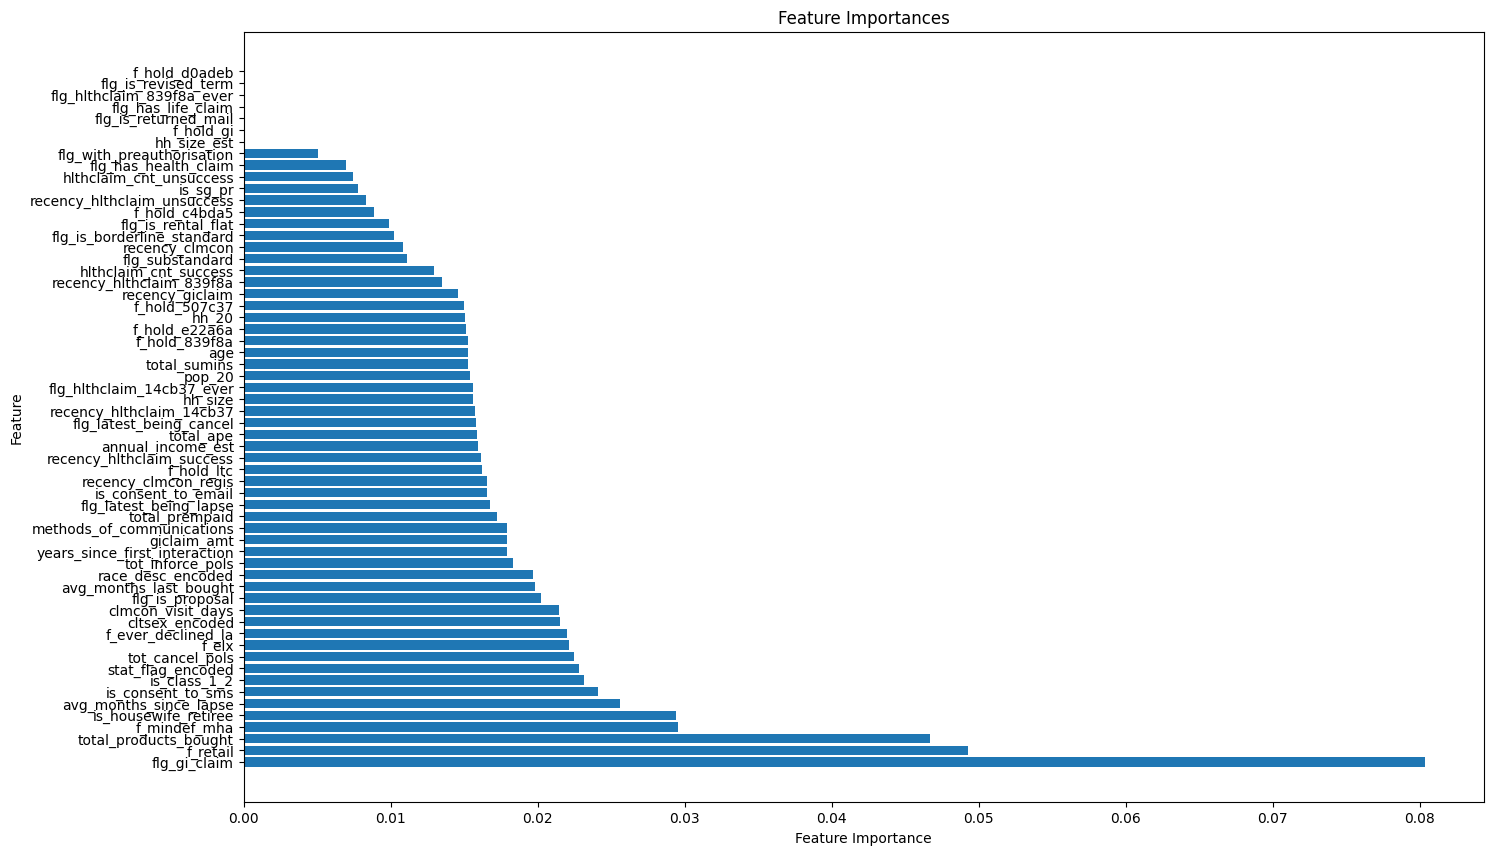

In [18]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and the target column is 'target_column'
# Replace 'target_column' with the actual name of your target column
target_variable = 'f_purchase_lh'

# Split your dataset into features and target
X = df.drop(columns=[target_variable])
y = df[target_variable]

# Create an XGBoost model
xgb_model = xgb.XGBClassifier()

# Fit the model on the training data
xgb_model.fit(X, y)

# Get feature importances from the trained model
feature_importances = xgb_model.feature_importances_

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print or visualize the feature importances
print(importance_df)

# You can also create plots to visualize the feature importances
plt.figure(figsize=(16, 10))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# Assuming df is your DataFrame
# Replace 'target_variable' with the actual name of your target variable
target_variable = 'f_purchase_lh'

# Split your dataset into features and target
X = df.drop(columns=[target_variable])
y = df[target_variable]

# Create a cross-validation iterator (StratifiedKFold for classification)
n_splits = 5  # You can adjust the number of folds as needed
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Create an XGBoost classifier
xgb_model = xgb.XGBClassifier()

# Lists to store results from each fold
accuracies = []

# Perform cross-validation
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model on the training data
    xgb_model.fit(X_train, y_train)

    # Predict on the test data
    y_pred = xgb_model.predict(X_test)

    # Calculate accuracy for this fold
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Calculate the mean and standard deviation of accuracies
mean_accuracy = sum(accuracies) / n_splits
std_accuracy = (sum((x - mean_accuracy) ** 2 for x in accuracies) / n_splits) ** 0.5

# Print cross-validation results
print(f'Mean Accuracy: {mean_accuracy:.2f}')
print(f'Standard Deviation of Accuracy: {std_accuracy:.2f}')

Mean Accuracy: 0.95
Standard Deviation of Accuracy: 0.00


## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [16]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform. 
    
All relevant code MUST be included in this function.'''
    result = [] 
    return result

##### Cell to check testing_hidden_data function

In [17]:
# This cell should output a list of predictions.
test_df = pd.read_parquet(filepath)
test_df = test_df.drop(columns=["f_purchase_lh"])
print(testing_hidden_data(test_df))

ImportError: Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.

### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!